Imports

In [1]:
#Data Manipulation and Analysis imports
import pandas as pd
import numpy as np

# Machine Learning imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
#Checks
data=pd.read_csv('/kaggle/input/test-file/tested.csv')
data.info()
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Data Cleaning and Feature Engineering

In [2]:
def fill_missing_values(df):
    age_fill_map={}
    for pclass in data["Pclass"].unique():
        if pclass not in age_fill_map:
            age_fill_map[pclass]=data[data["Pclass"]==pclass]["Age"].median()
    data["Age"]=data.apply(lambda row: age_fill_map[row["Pclass"]] if pd.isnull(row["Age"]) else row["Age"],axis=1)
    


In [3]:
def preprocess_data(data):
    data.drop(columns=['Name','Ticket','Cabin',"Embarked"],inplace=True)
    #data.drop(columns=["Embarked"], inplace=True)
    #Convert Gender to numerical
    data['Sex']=data["Sex"].map({'male': 0, 'female': 1})

    fill_missing_values(data)
    data.drop(columns=['PassengerId'],inplace=True)
    data.dropna(inplace=True)

    #Feature Egineering
    data["FamilySize"]=data["SibSp"]+data["Parch"]
    data["IsAlone"]=np.where(data["FamilySize"]==0,1,0)
    data["FareBin"]=pd.qcut(data["Fare"],4,labels=False)
    data["AgeBin"]=pd.cut(data["Age"], bins=[0,12,20,40,60, np.inf],labels=False)

    return data

Machine Learning

In [4]:
#Target Variables and Features
data =preprocess_data(data)
X=data.drop(columns=["Survived"])
Y=data["Survived"]
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.50,random_state=42)
#ML Preprocessing
scaler=MinMaxScaler()
X_train=scaler.fit_transform(x_train)
X_test=scaler.transform(x_test)
#Hyperparameter Tuning -KNN Model
def tune_model(X_train,y_train):
    param_grid={
        "n_neighbors":range(1,21),
        "metric":['euclidean','manhattan','minkowski'],#research what these metrics do
        "weights":['uniform','distance']#uniform: all points in each neighborhood are weighted equally. distance: closer neighbors of a query point will have a greater influence than neighbors which are further away.
    }
    model=KNeighborsClassifier()
    grid_search=GridSearchCV(estimator=model,param_grid=param_grid,cv=5,n_jobs=-1)
    grid_search.fit(X_train,y_train)
    return grid_search.best_estimator_
#Train the model
best_knn_model=tune_model(X_train,y_train)

Predictions

In [5]:
def evaluate_model(model,X_test,y_test):
    prediction=model.predict(X_test)
    accuracy=accuracy_score(y_test,prediction)
    conf_matrix=confusion_matrix(y_test,prediction)
    return accuracy,conf_matrix

accuracy, matrix=evaluate_model(best_knn_model,X_test,y_test)
print(f"Model Accuracy: {accuracy*100:.2f}%")
print("Confusion Matrix:")
print(matrix)

Model Accuracy: 99.52%
Confusion Matrix:
[[135   0]
 [  1  73]]


Plot

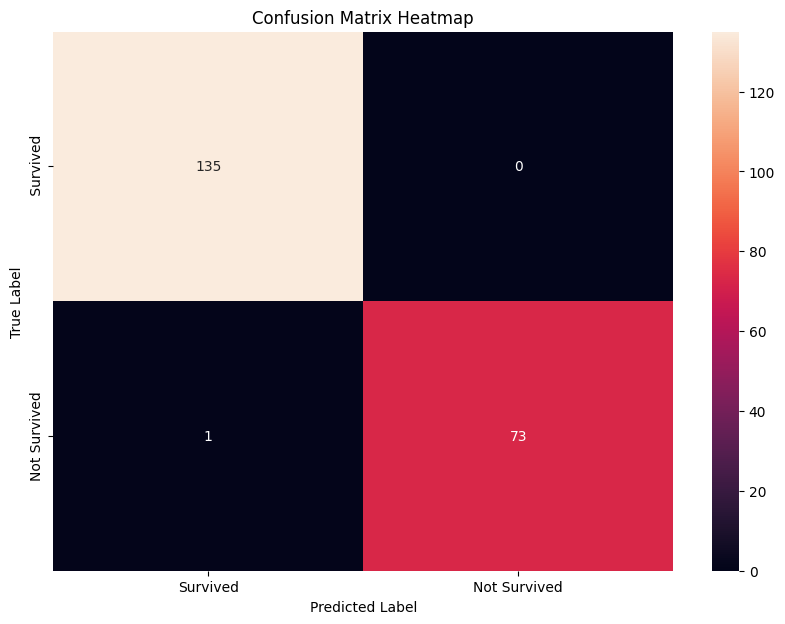

In [6]:
def plot_model(matrix):
    plt.figure(figsize=(10,7))
    sns.heatmap(matrix,annot=True,fmt='d',xticklabels=["Survived","Not Survived"],yticklabels=[
    " Survived","Not Survived"])
    plt.title("Confusion Matrix Heatmap")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
plot_model(matrix)